In [ ]:
%load_ext sql
%sql sqlite:///lab.db

In [ ]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
# maximum number of rows to display
pd.options.display.max_rows = 50

In [ ]:
connection = sqlite3.connect(r'/content/bike_store.db')

In [ ]:
stocks = pd.read_csv(r'/content/stocks.csv')
stocks
stores = pd.read_csv(r'/content/stores.csv')
stores
staffs = pd.read_csv(r'/content/staffs.csv')
staffs
products = pd.read_csv(r'/content/products.csv')
products
orders = pd.read_csv(r'/content/orders.csv')
orders

,order_id,customer_id,order_status,order_date,required_date,shipped_date,store_id,staff_id
0,1,259,4,2016-01-01,2016-01-03,2016-01-03,1,2
1,2,1212,4,2016-01-01,2016-01-04,2016-01-03,2,6
2,3,523,4,2016-01-02,2016-01-05,2016-01-03,2,7
3,4,175,4,2016-01-03,2016-01-04,2016-01-05,1,3
4,5,1324,4,2016-01-03,2016-01-06,2016-01-06,2,6
...,...,...,...,...,...,...,...,...
1610,1611,6,3,2018-09-06,2018-09-06,NaN,2,7
1611,1612,3,3,2018-10-21,2018-10-21,NaN,1,3
1612,1613,1,3,2018-11-18,2018-11-18,NaN,2,6
1613,1614,135,3,2018-11-28,2018-11-28,NaN,3,8


In [ ]:
orders_items = pd.read_csv(r'/content/order_items.csv')
orders_items
customers = pd.read_csv(r'/content/customers.csv')
customers
categories = pd.read_csv(r'/content/categories.csv')
categories
brands = pd.read_csv(r'/content/brands.csv')
brands

,brand_id,brand_name
0,1,Electra
1,2,Haro
2,3,Heller
3,4,Pure Cycles
4,5,Ritchey
5,6,Strider
6,7,Sun Bicycles
7,8,Surly
8,9,Trek


- Established a detailed employee hierarchy using recursive SQL queries to better understand organizational structure and reporting lines.
- Calculated the 30-day moving average of orders to identify trends and monitor performance over time.
- Conducted customer segmentation based on order count, total spent, and recency to tailor marketing strategies and improve customer relationship management.
- Performed seasonality and ranking analysis to identify peak sales periods and top-performing products.
- Executed market basket analysis to uncover frequently co-purchased products, aiding in cross-selling and upselling strategies.
- Analyzed average time intervals between consecutive purchases to understand customer buying patterns and optimize re-engagement tactics.




In [ ]:
brands.to_sql("brands", connection, if_exists = "replace", index = False)
categories.to_sql("categories", connection, if_exists = "replace", index = False)
customers.to_sql("customers", connection, if_exists = "replace", index = False)
orders_items.to_sql("orders_items", connection, if_exists = "replace", index = False)
orders.to_sql("orders", connection, if_exists = "replace", index = False)
products.to_sql("products", connection, if_exists = "replace", index = False)
staffs.to_sql("staffs", connection, if_exists = "replace", index = False)
stores.to_sql("stores", connection, if_exists = "replace", index = False)
stocks.to_sql("stocks", connection, if_exists = "replace", index = False)

939

In [ ]:
# extract the trekking products of 2019 which are above the avg price.
#tables: products


pd.read_sql("""

SELECT p.product_name as name, list_price
FROM products as p
Where p.brand_id = 9 AND model_year = 2019 AND list_price > (SELECT avg(list_price) from products where model_year = 2019)
;

""", connection)




,name,list_price
0,Trek Checkpoint SL 5 Women's - 2019,2799.99
1,Trek Checkpoint SL 6 - 2019,3799.99
2,Trek Checkpoint ALR Frameset - 2019,3199.99


In [ ]:
#how you get what thebrand id for trek is and then you apply that above
pd.read_sql("""

select DISTINCT brand_id from products where product_name LIKE '%Trek%';

""", connection)

,brand_id
0,9


In [ ]:
pd.read_sql("""

select * from orders_items;

""", connection)

,order_id,item_id,product_id,quantity,list_price,discount
0,1,1,20,1,599.99,0.20
1,1,2,8,2,1799.99,0.07
2,1,3,10,2,1549.00,0.05
3,1,4,16,2,599.99,0.05
4,1,5,4,1,2899.99,0.20
...,...,...,...,...,...,...
4717,1614,2,159,2,2299.99,0.07
4718,1614,3,213,2,269.99,0.20
4719,1615,1,197,2,2299.99,0.20
4720,1615,2,214,1,899.99,0.07


In [ ]:
# extract only those order id and customer
#id where we have trekking producs discounted with atleast 20% and there can be
# duplicate id for customers with more than one order.

#need orders tableand orders_items

pd.read_sql("""

select orders.order_id, orders.customer_id from orders_items inner join orders
on orders.order_id = orders_items.order_id
inner join  products on orders_items.product_id = products.product_id where
orders_items.discount >= 0.20
AND products.brand_id = 9 ;

""", connection)

,order_id,customer_id
0,1,259
1,45,1220
2,48,1012
3,94,929
4,128,86
...,...,...
320,1381,680
321,1602,55
322,1485,51
323,1391,914


In [ ]:
pd.read_sql("""

SELECT Distinct order_id, customer_id from orders
where order_id in (
    select Distinct order_id from orders_items o
    join products p on o.product_id = p.product_id
    where discount >= 0.2 AND brand_id = 9
)
GROUP BY order_id;

""", connection)

,order_id,customer_id
0,1,259
1,16,552
2,19,696
3,28,252
4,29,437
...,...,...
293,1601,43
294,1602,55
295,1605,123
296,1610,15


In [ ]:
#- Calculated the 30-day moving average of orders to identify trends and monitor performance over time.
moving_avg = pd.read_sql("""
WITH daily_orders AS (
    SELECT
        order_date,
        store_id,
        COUNT(*) AS orders
    FROM
        orders
    GROUP BY
        1,2
)

SELECT
    order_date,
    store_id,
    AVG(orders) OVER(PARTITION BY store_id
                     ORDER BY order_date ASC
                     ROWS BETWEEN 14 PRECEDING AND 15 FOLLOWING) AS moving_avg_30d
FROM
    daily_orders
order by order_date;
""", connection)

In [ ]:
 moving_avg

,order_date,store_id,moving_avg_30d
0,2016-01-01,1,1.250000
1,2016-01-01,2,1.750000
2,2016-01-02,2,1.764706
3,2016-01-03,1,1.235294
4,2016-01-03,2,1.777778
...,...,...,...
1049,2018-09-06,2,1.750000
1050,2018-10-21,1,2.266667
1051,2018-11-18,2,1.733333
1052,2018-11-28,3,1.187500


[]

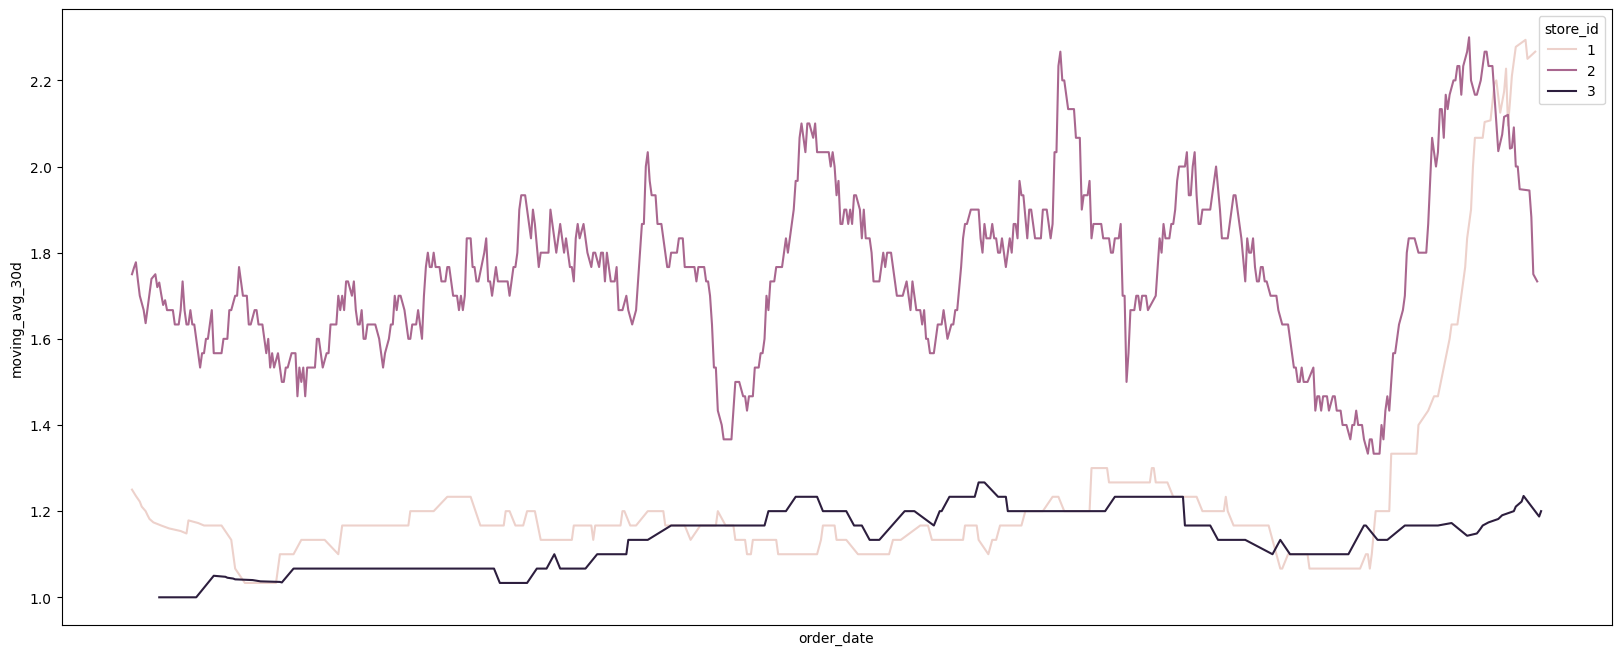

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=moving_avg, x='order_date', y='moving_avg_30d', hue='store_id', ax=ax)
ax.set_xticks([])
#how we are ocmbinign sqlite with python

In [ ]:
#- Conducted customer segmentation based on order count,
# total spent, and recency to tailor marketing strategies and improve customer relationship management.
pd.read_sql("""
SELECT
    c.customer_id,
    c.first_name || ' ' || c.last_name AS customer_name,
    COUNT(DISTINCT o.order_id) AS order_count,
    SUM(oi.quantity * oi.list_price * (1 - oi.discount)) AS total_spent,
    JULIANDAY('now') - JULIANDAY(MAX(o.order_date)) AS recency
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_id
ORDER BY total_spent DESC, recency ASC;
""", connection)

## JULIANDAY('now') tells sqlite to use current date

,customer_id,customer_name,order_count,total_spent,recency
0,94,Sharyn Hopkins,2,34807.9392,2480.120093
1,10,Pamelia Newman,3,33634.2604,2336.120093
2,75,Abby Gamble,2,32803.0062,2473.120093
3,6,Lyndsey Bean,3,32675.0725,2322.120093
4,16,Emmitt Sanchez,3,31925.8857,2472.120093
...,...,...,...,...,...
1440,1111,Caroline Jenkins,1,170.9910,2653.120093
1441,752,Lloyd Miranda,1,170.9910,2696.120093
1442,177,Carissa Foreman,1,170.9910,2824.120093
1443,718,Luciana Mcgee,1,167.9920,2788.120093


In [ ]:
summary = pd.read_sql("""

SELECT
    o.customer_id, COUNT(DISTINCT oi.order_id) AS order_count,
    SUM(oi.list_price * oi.quantity *(1-oi.discount)) AS total_spent,
    julianday('2018-12-28') - julianday(MAX(order_date)) AS days_since_last_purchase,
    CASE
    WHEN julianday('2018-12-28') - julianday(MAX(order_date)) < 270 THEN '3months_dormant'
    WHEN julianday('2018-12-28') - julianday(MAX(order_date)) BETWEEN 271 AND 540 THEN '3 to 6 months_dormant'
    WHEN julianday('2018-12-28') - julianday(MAX(order_date)) BETWEEN 541 AND 810 THEN '6 to 12 months_dormant'
    ELSE 'more then 12 months_dormant'
    END AS dormant_bucket
FROM orders o
join orders_items oi
on o.order_id = oi.order_id
group by 1
order by 2 desc;

""", connection)
summary

,customer_id,order_count,total_spent,days_since_last_purchase,dormant_bucket
0,116,3,12793.6337,257.0,3months_dormant
1,77,3,8522.9542,252.0,3months_dormant
2,68,3,10802.6294,263.0,3months_dormant
3,66,3,23026.2923,261.0,3months_dormant
4,64,3,8778.1311,268.0,3months_dormant
...,...,...,...,...,...
1440,100,1,5399.9820,306.0,3 to 6 months_dormant
1441,99,1,5431.8955,992.0,more then 12 months_dormant
1442,98,1,2546.4665,979.0,more then 12 months_dormant
1443,96,1,7681.1240,748.0,6 to 12 months_dormant


([0, 1, 2, 3],
 [Text(0, 0, '3months_dormant'),
  Text(1, 0, '6 to 12 months_dormant'),
  Text(2, 0, 'more then 12 months_dormant'),
  Text(3, 0, '3 to 6 months_dormant')])

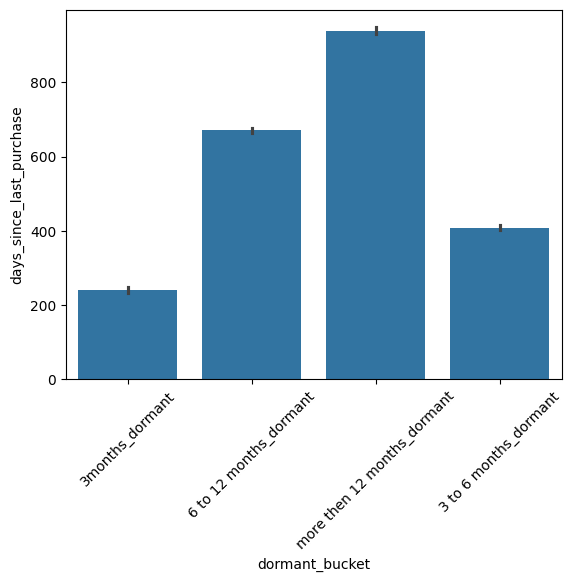

In [ ]:
sns.barplot(data = summary, x = 'dormant_bucket', y = 'days_since_last_purchase')
plt.xticks(rotation = 45)


In [ ]:
#- Performed seasonality and ranking analysis to identify peak sales periods and top-performing products.
# extract the customer segmentation based on purchase frequency (if total order > 1 then repeat buyer otherwise one time
# buyer), purchase recency (if days since last purchase less then 90 then recent buyer otherwise not recent) and buying
# power (proportion of total spent >=70% then big spender, <= 30% low spender, otherwise average spender)


# Tables and Columns Used:

# Table: customers
# Columns: customer_id

# Table: orders
# Columns: order_id, customer_id, order_date

# Table: order_items
# Columns: order_id, product_id, quantity, list_price, discount

# Table: products
# Columns: product_id, product_name


In [ ]:
summary1 = pd.read_sql("""
WITH Common_table as
(SELECT
    o.customer_id,
    COUNT(DISTINCT oi.order_id) as order_count,
    julianday('2018-12-28') - julianday(MAX(o.order_date)) AS days_since_last_purchase,
    SUM(oi.list_price * oi.quantity *(1-oi.discount)) AS total_spent
FROM orders o
join orders_items oi
on o.order_id = oi.order_id
GROUP BY 1)
SELECT customer_id,
    CASE WHEN order_count > 1 THEN 'Repeat buyer'
    ELSE 'one time buyer' END AS purchase_freq,
    CASE WHEN days_since_last_purchase < 90 THEN 'recent buyer'
    ELSE 'non recent' END AS 'perchase recency',
    CASE WHEN total_spent/(SELECT MAX(total_spent) FROM Common_table)>=0.70 THEN 'big spender'
    WHEN total_spent/(SELECT MAX(total_spent) FROM Common_table)<=0.30 THEN 'low spender'
    ELSE 'average spender' END AS 'buying power'
FROM Common_table;

""", connection)
summary1

,customer_id,purchase_freq,perchase recency,buying power
0,1,Repeat buyer,recent buyer,big spender
1,2,Repeat buyer,non recent,average spender
2,3,Repeat buyer,recent buyer,average spender
3,4,Repeat buyer,non recent,average spender
4,5,Repeat buyer,non recent,average spender
...,...,...,...,...
1440,1441,one time buyer,non recent,low spender
1441,1442,one time buyer,non recent,low spender
1442,1443,one time buyer,non recent,low spender
1443,1444,one time buyer,non recent,low spender


Text(0.5, 1.0, 'Buying Power')

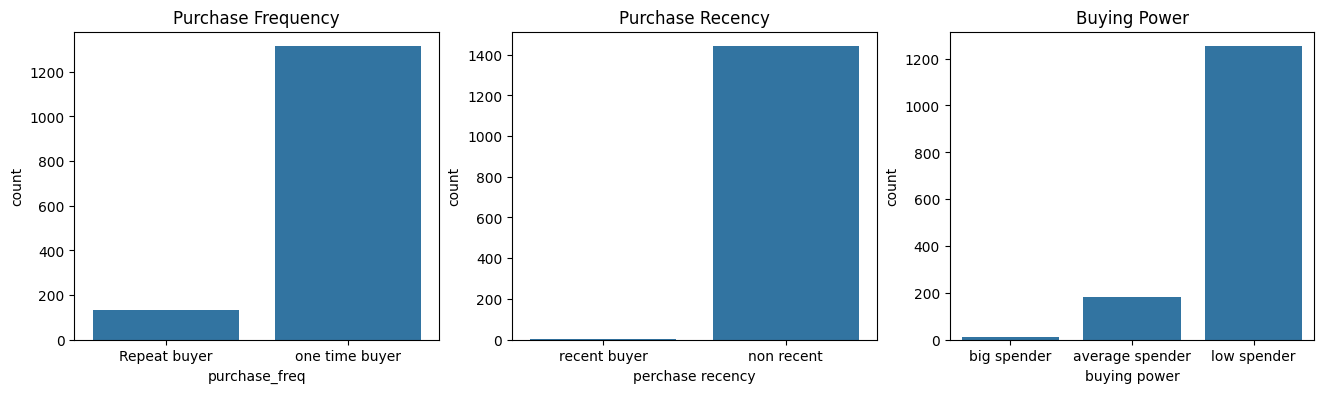

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
sns.countplot(data = summary1, x = 'purchase_freq', ax = ax[0])
sns.countplot(data = summary1, x = 'perchase recency', ax = ax[1])
sns.countplot(data = summary1, x = 'buying power', ax = ax[2])

ax[0].set_title('Purchase Frequency')
ax[1].set_title('Purchase Recency')
ax[2].set_title('Buying Power')

In [ ]:
# inner query 1 - join to have product_id with category name
# inner query 2 - extract year and month from order date along with product id, total unit sold from order and orders_items tables
# outer query - to pull the month, category name, average of total unit sold by joining inner query 1 and 2.

seasonality1 = pd.read_sql("""

With table1 as(
SELECT *
FROM products as p
JOIN categories as c
ON p.category_id  = c.category_id
),
table2 as(
SELECT oi.product_id,
strftime('%m', o.order_date) as month,
strftime('%Y', o.order_date) as year,
SUM(oi.quantity) as total_units
FROM orders as o
        JOIN
    orders_items as oi
        ON o.order_id = oi.order_id
GROUP BY 1,2,3
)

SELECT t1.category_name, t2.month, avg(t2.total_units) as avg_units
FROM table1 as t1
JOIN table2 as t2
ON t1.product_id = t2.product_id
GROUP BY 1,2;

""", connection)
seasonality1

,category_name,month,avg_units
0,Children Bicycles,01,2.973684
1,Children Bicycles,02,3.150000
2,Children Bicycles,03,2.920000
3,Children Bicycles,04,3.000000
4,Children Bicycles,05,3.050000
...,...,...,...
79,Road Bikes,08,2.666667
80,Road Bikes,09,2.818182
81,Road Bikes,10,2.300000
82,Road Bikes,11,2.307692


<Axes: xlabel='month', ylabel='avg_units'>

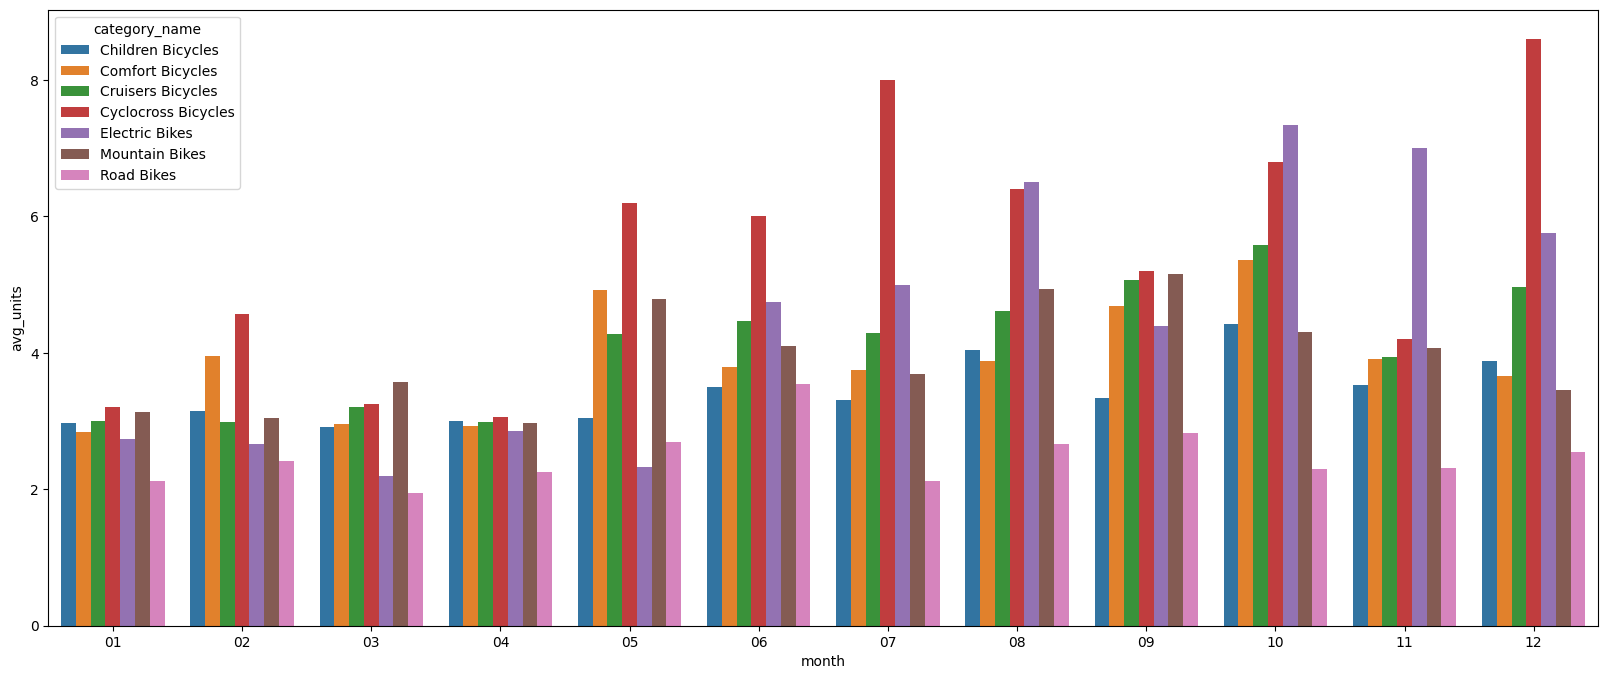

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data = seasonality1, x = 'month', y = 'avg_units', hue = 'category_name', ax=ax)

In [ ]:
# Performed seasonality and ranking analysis to identify peak sales periods and top-performing products.

seasonality = pd.read_sql("""

SELECT
    product_id,
    strftime('%Y-%m', order_date) as months,
    SUM(oi.list_price * oi.quantity *(1-oi.discount)) AS Sales
FROM
    orders as o
        JOIN
    orders_items as oi
        ON o.order_id = oi.order_id
GROUP BY 2
ORDER BY 2;
""", connection)
seasonality

,product_id,months,Sales
0,4,2016-01,215146.4241
1,13,2016-02,156112.3228
2,7,2016-03,180600.3285
3,8,2016-04,167144.0512
4,6,2016-05,205270.0091
5,7,2016-06,210562.1245
6,7,2016-07,199556.8089
7,14,2016-08,225657.3767
8,5,2016-09,273091.6097
9,11,2016-10,212078.0805


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 [Text(0, 0, '2016-01'),
  Text(1, 0, '2016-02'),
  Text(2, 0, '2016-03'),
  Text(3, 0, '2016-04'),
  Text(4, 0, '2016-05'),
  Text(5, 0, '2016-06'),
  Text(6, 0, '2016-07'),
  Text(7, 0, '2016-08'),
  Text(8, 0, '2016-09'),
  Text(9, 0, '2016-10'),
  Text(10, 0, '2016-11'),
  Text(11, 0, '2016-12'),
  Text(12, 0, '2017-01'),
  Text(13, 0, '2017-02'),
  Text(14, 0, '2017-03'),
  Text(15, 0, '2017-04'),
  Text(16, 0, '2017-05'),
  Text(17, 0, '2017-06'),
  Text(18, 0, '2017-07'),
  Text(19, 0, '2017-08'),
  Text(20, 0, '2017-09'),
  Text(21, 0, '2017-10'),
  Text(22, 0, '2017-11'),
  Text(23, 0, '2017-12'),
  Text(24, 0, '2018-01'),
  Text(25, 0, '2018-02'),
  Text(26, 0, '2018-03'),
  Text(27, 0, '2018-04'),
  Text(28, 0, '2018-06'),
  Text(29, 0, '2018-07'),
  Text(30, 0, '2018-08'),
  T

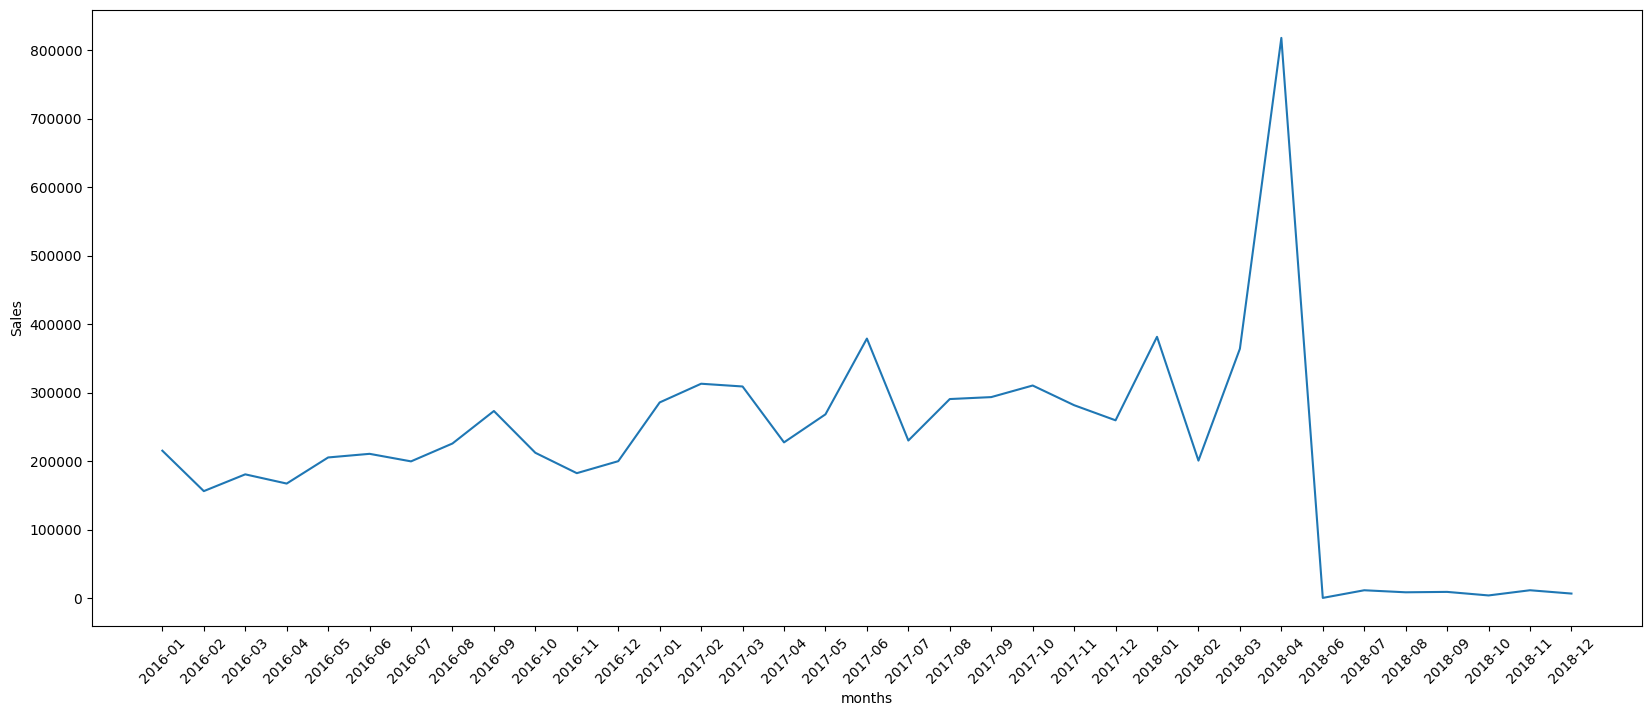

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data = seasonality, x = 'months', y = 'Sales', ax = ax)
plt.xticks(rotation = 45)

In [ ]:
top_performers = pd.read_sql("""

SELECT
    oi.product_id,
    p.product_name,
    b.brand_name,
    SUM(oi.list_price * oi.quantity *(1-oi.discount)) AS Sales,
    ROW_NUMBER () OVER(ORDER BY SUM(oi.list_price * oi.quantity *(1-oi.discount)) DESC) AS rank
FROM
    products as p
        JOIN
    orders_items as oi
        ON p.product_id = oi.product_id
        JOIN
    brands as b
        ON b.brand_id = p.brand_id
GROUP BY 1
ORDER BY 5
limit 10;

""", connection)
top_performers

,product_id,product_name,brand_name,Sales,rank
0,7,Trek Slash 8 27.5 - 2016,Trek,555558.6111,1
1,9,Trek Conduit+ - 2016,Trek,389248.7025,2
2,4,Trek Fuel EX 8 29 - 2016,Trek,368472.7294,3
3,11,Surly Straggler 650b - 2016,Surly,226765.5510,4
4,56,Trek Domane SLR 6 Disc - 2017,Trek,211584.6153,5
5,10,Surly Straggler - 2016,Surly,203507.6200,6
6,8,Trek Remedy 29 Carbon Frameset - 2016,Trek,203380.8701,7
7,61,Trek Powerfly 8 FS Plus - 2017,Trek,188249.6235,8
8,58,Trek Madone 9.2 - 2017,Trek,175899.6482,9
9,51,Trek Silque SLR 8 Women's - 2017,Trek,174524.7315,10


In [ ]:
#  Executed market basket analysis to uncover frequently co-purchased products, aiding in cross-selling and upselling strategies.
#Generate product pairings from the same order
product_pairings = pd.read_sql("""SELECT
    oi1.product_id AS product_a,
    oi2.product_id AS product_b,
    COUNT(*) AS co_purchase_count
FROM order_items oi1
JOIN order_items oi2
    ON oi1.order_id = oi2.order_id
    AND oi1.product_id < oi2.product_id
GROUP BY product_a, product_b
HAVING co_purchase_count > 1
ORDER BY co_purchase_count DESC
LIMIT 20; """, connection)
product_pairings

,product_a,product_b,co_purchase_count
0,5,14,15
1,9,11,14
2,12,13,14
3,15,21,14
4,9,10,13
5,18,21,13
6,22,23,13
7,3,6,12
8,3,9,12
9,3,15,12


In [ ]:
# Query to fetch data from the product_pairings table
query = pd.read_sql("""
    SELECT product_a, product_b, co_purchase_count
    FROM (SELECT
    oi1.product_id AS product_a,
    oi2.product_id AS product_b,
    COUNT(*) AS co_purchase_count
FROM order_items oi1
JOIN order_items oi2
    ON oi1.order_id = oi2.order_id
    AND oi1.product_id < oi2.product_id
GROUP BY product_a, product_b
HAVING co_purchase_count > 1
ORDER BY co_purchase_count DESC
LIMIT 20) as new_table
""",connection)






In [ ]:
query

,product_a,product_b,co_purchase_count
0,5,14,15
1,9,11,14
2,12,13,14
3,15,21,14
4,9,10,13
5,18,21,13
6,22,23,13
7,3,6,12
8,3,9,12
9,3,15,12


In [ ]:

# Pivot the data for the heatmap
pivot = pd.pivot_table( query, values='co_purchase_count', index='product_a', columns='product_b', aggfunc='sum',fill_value = 0)

pivot

product_b,6,7,9,10,11,12,13,14,15,18,21,22,23,25,26
product_a,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0
3,12,0,12,0,0,0,0,0,12,12,0,0,0,0,0
4,0,0,0,0,0,11,0,0,0,12,0,11,0,0,0
5,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0
6,0,11,0,0,0,0,11,0,0,0,0,0,0,11,0
8,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0
9,0,0,0,13,14,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0


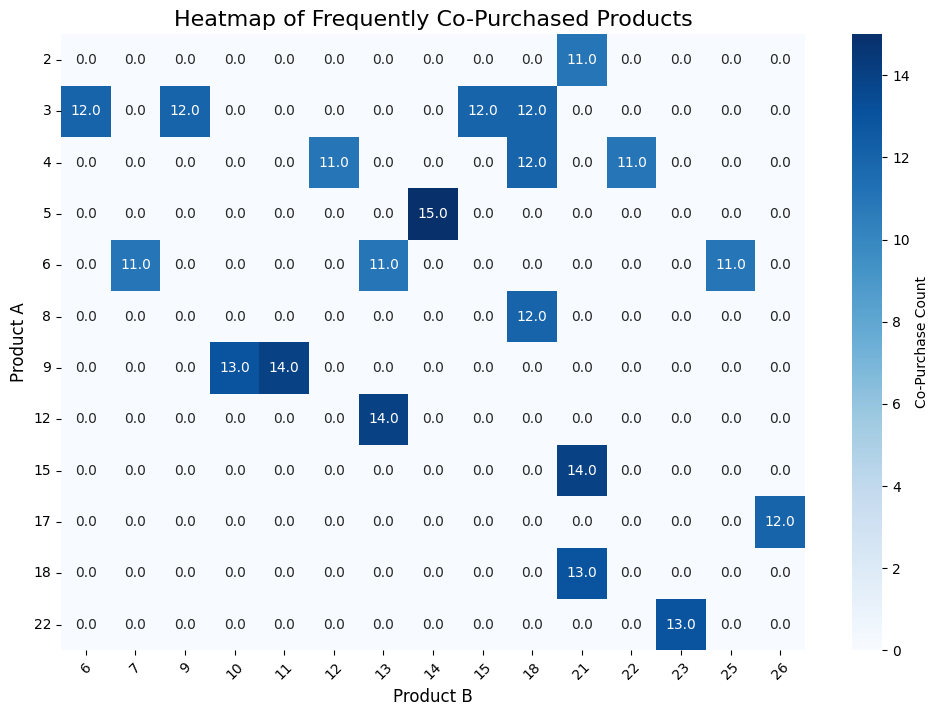

In [ ]:
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Co-Purchase Count'})
plt.title("Heatmap of Frequently Co-Purchased Products", fontsize=16)
plt.xlabel("Product B", fontsize=12)
plt.ylabel("Product A", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
basket = pd.read_sql("""
SELECT
    product_a,
    product_b,
    co_purchase_count
FROM
    (
     SELECT
         p1.product_name AS product_a,
         p2.product_name AS product_b,
         COUNT(*) AS co_purchase_count
     FROM
         orders_items s1
     INNER JOIN
         orders_items s2 ON s1.order_id = s2.order_id AND s1.product_id <> s2.product_id
     INNER JOIN
         products p1 ON s1.product_id = p1.product_id
     INNER JOIN
         products p2 ON s2.product_id = p2.product_id
     GROUP BY
         p1.product_id, p2.product_id
    ) subquery
ORDER BY
    co_purchase_count DESC;

""", connection)
basket

,product_a,product_b,co_purchase_count
0,Heller Shagamaw Frame - 2016,Electra Girl's Hawaii 1 (16-inch) - 2015/2016,15
1,Electra Girl's Hawaii 1 (16-inch) - 2015/2016,Heller Shagamaw Frame - 2016,15
2,Trek Conduit+ - 2016,Surly Straggler 650b - 2016,14
3,Surly Straggler 650b - 2016,Trek Conduit+ - 2016,14
4,Electra Townie Original 21D - 2016,Electra Cruiser 1 (24-Inch) - 2016,14
...,...,...,...
6923,Electra Townie Original 21D EQ Ladies' - 2018,Trek X-Caliber Frameset - 2018,1
6924,Electra Townie Original 21D Ladies' - 2018,Trek Girl's Kickster - 2017,1
6925,Electra Townie Original 21D Ladies' - 2018,Trek Domane SL 8 Disc - 2018,1
6926,Electra Townie Original 21D Ladies' - 2018,Trek Conduit+ - 2018,1


In [ ]:
# Apriori algorithm for market basket analysis
from mlxtend.frequent_patterns import apriori, association_rules
all_products = sorted(set(basket['product_a']).union(set(basket['product_b'])))
all_products


["Electra Amsterdam Fashion 3i Ladies' - 2017/2018",
 "Electra Amsterdam Fashion 7i Ladies' - 2017",
 'Electra Amsterdam Original 3i - 2015/2017',
 "Electra Amsterdam Original 3i Ladies' - 2017",
 'Electra Amsterdam Royal 8i Ladies - 2018',
 'Electra Cruiser 1 (24-Inch) - 2016',
 'Electra Cruiser 1 - 2016/2017/2018',
 "Electra Cruiser 1 Ladies' - 2018",
 'Electra Cruiser 1 Tall - 2016/2018',
 "Electra Cruiser 7D (24-Inch) Ladies' - 2016/2018",
 'Electra Cruiser 7D - 2016/2017/2018',
 "Electra Cruiser 7D Ladies' - 2016/2018",
 'Electra Cruiser 7D Tall - 2016/2018',
 'Electra Cruiser Lux 1 - 2016/2018',
 'Electra Cruiser Lux 1 - 2017',
 "Electra Cruiser Lux 1 Ladies' - 2018",
 'Electra Cruiser Lux 3i - 2018',
 "Electra Cruiser Lux 3i Ladies' - 2018",
 'Electra Cruiser Lux 7D - 2018',
 "Electra Cruiser Lux 7D Ladies' - 2018",
 'Electra Cruiser Lux Fat Tire 1 Ladies - 2017',
 'Electra Cruiser Lux Fat Tire 7D - 2018',
 "Electra Cyclosaurus 1 (16-inch) - Boy's - 2018",
 "Electra Daydreamer 3

In [ ]:
transactions = {product: [] for product in all_products}
transactions

{"Electra Amsterdam Fashion 3i Ladies' - 2017/2018": [],
 "Electra Amsterdam Fashion 7i Ladies' - 2017": [],
 'Electra Amsterdam Original 3i - 2015/2017': [],
 "Electra Amsterdam Original 3i Ladies' - 2017": [],
 'Electra Amsterdam Royal 8i Ladies - 2018': [],
 'Electra Cruiser 1 (24-Inch) - 2016': [],
 'Electra Cruiser 1 - 2016/2017/2018': [],
 "Electra Cruiser 1 Ladies' - 2018": [],
 'Electra Cruiser 1 Tall - 2016/2018': [],
 "Electra Cruiser 7D (24-Inch) Ladies' - 2016/2018": [],
 'Electra Cruiser 7D - 2016/2017/2018': [],
 "Electra Cruiser 7D Ladies' - 2016/2018": [],
 'Electra Cruiser 7D Tall - 2016/2018': [],
 'Electra Cruiser Lux 1 - 2016/2018': [],
 'Electra Cruiser Lux 1 - 2017': [],
 "Electra Cruiser Lux 1 Ladies' - 2018": [],
 'Electra Cruiser Lux 3i - 2018': [],
 "Electra Cruiser Lux 3i Ladies' - 2018": [],
 'Electra Cruiser Lux 7D - 2018': [],
 "Electra Cruiser Lux 7D Ladies' - 2018": [],
 'Electra Cruiser Lux Fat Tire 1 Ladies - 2017': [],
 'Electra Cruiser Lux Fat Tire 7

In [ ]:
for _, row in basket.iterrows():
    transactions[row['product_a']].append(row['product_b'])
    transactions[row['product_b']].append(row['product_a'])

In [ ]:
encoded_data = []
for product in all_products:
    encoded_row = {item: (item in transactions[product]) for item in all_products}
    encoded_data.append(encoded_row)

In [ ]:
df_encoded_bskt = pd.DataFrame(encoded_data, index=all_products)

In [ ]:
#!pip install apriori

  Preparing metadata (setup.py) ... done
  Created wheel for apriori: filename=apriori-1.0.0-py3-none-any.whl size=2454 sha256=827a40cf4cf539d02ad7304f2b4578ae4f913ae092ca64cfe9df4d2ad7b1fb55
  Stored in directory: /root/.cache/pip/wheels/8c/fa/83/25b9cb17d884f97f2e62d97d0818bbed8117e89a6b09c37dc3
Successfully built apriori


In [ ]:
frequent_itemsets = apriori(df_encoded_bskt, min_support=0.1, use_colnames=True)
print(frequent_itemsets)

       support                                           itemsets
0     0.188406      (Electra Amsterdam Fashion 7i Ladies' - 2017)
1     0.144928        (Electra Amsterdam Original 3i - 2015/2017)
2     0.173913     (Electra Amsterdam Original 3i Ladies' - 2017)
3     0.304348               (Electra Cruiser 1 (24-Inch) - 2016)
4     0.123188                     (Electra Cruiser Lux 1 - 2017)
...        ...                                                ...
2940  0.101449  (Surly Ice Cream Truck Frameset - 2016, Electr...
2941  0.101449  (Electra Townie Original 7D EQ - 2016, Electra...
2942  0.108696  (Surly Ice Cream Truck Frameset - 2016, Electr...
2943  0.101449  (Electra Townie Original 7D EQ - 2016, Surly I...
2944  0.101449  (Electra Townie Original 7D EQ - 2016, Surly I...

[2945 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5,num_itemsets = 3)
rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Electra Amsterdam Fashion 7i Ladies' - 2017),(Electra Cruiser 1 (24-Inch) - 2016),0.188406,0.304348,0.134058,0.711538,2.337912,1.0,0.076717,2.411594,0.705116,0.373737,0.585337,0.576007
1,(Electra Amsterdam Fashion 7i Ladies' - 2017),(Electra Girl's Hawaii 1 (16-inch) - 2015/2016),0.188406,0.289855,0.130435,0.692308,2.388462,1.0,0.075824,2.307971,0.716270,0.375000,0.566719,0.571154
2,(Electra Amsterdam Fashion 7i Ladies' - 2017),"(Electra Girl's Hawaii 1 16"" - 2017)",0.188406,0.289855,0.115942,0.615385,2.123077,1.0,0.061332,1.846377,0.651786,0.320000,0.458399,0.507692
3,(Electra Amsterdam Fashion 7i Ladies' - 2017),(Electra Townie Original 21D - 2016),0.188406,0.326087,0.119565,0.634615,1.946154,1.0,0.058129,1.844394,0.599026,0.302752,0.457816,0.500641
4,(Electra Amsterdam Fashion 7i Ladies' - 2017),(Electra Townie Original 7D - 2017),0.188406,0.264493,0.105072,0.557692,2.108535,1.0,0.055240,1.662886,0.647783,0.302083,0.398636,0.477476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18551,"(Heller Shagamaw Frame - 2016, Electra Girl's ...",(Electra Townie Original 7D EQ - Women's - 201...,0.170290,0.115942,0.101449,0.595745,5.138298,1.0,0.081706,2.186880,0.970680,0.549020,0.542728,0.735372
18552,(Electra Townie Original 7D EQ - Women's - 201...,"(Electra Townie Original 7D EQ - 2016, Heller ...",0.173913,0.119565,0.101449,0.583333,4.878788,1.0,0.080655,2.113043,0.962406,0.528302,0.526749,0.715909
18553,"(Heller Shagamaw Frame - 2016, Electra Townie ...",(Electra Townie Original 7D EQ - Women's - 201...,0.181159,0.123188,0.101449,0.560000,4.545882,1.0,0.079133,1.992754,0.952592,0.500000,0.498182,0.691765
18554,(Electra Townie Original 7D EQ - Women's - 201...,"(Electra Townie Original 7D EQ - 2016, Electra...",0.152174,0.137681,0.101449,0.666667,4.842105,1.0,0.080498,2.586957,0.935897,0.538462,0.613445,0.701754


The output shows the result of association rule mining especially using the association rules function

antecedents: The itemsets that appear before the rule (the "if" part).

consequents: The itemsets that appear after the rule (the "then" part).

antecedent support: The support (frequency) of the antecedent itemset.

consequent support: The support (frequency) of the consequent itemset.

support: The joint support of both the antecedent and the consequent (i.e., how often both appear together).

confidence: The likelihood that the consequent is present given that the antecedent is present, calculated as
support(antecedent, consequent)

lift: The ratio of the observed support to that expected if the antecedent and consequent were independent. A lift greater than 1 suggests a positive correlation.

leverage: The difference between the observed support and the expected support if the antecedent and consequent were independent. Positive leverage indicates a positive association.

conviction: A measure of the dependence of the consequent on the antecedent. Higher values indicate stronger rules.

zhangs_metric: Another metric for evaluating the strength of association rules, with values typically between -1 and 1, where values close to 1 indicate strong positive association.

High Confidence and Lift:

Rules with high confidence (close to 1) indicate strong predictive power. For example, the rule (Electra Amsterdam Fashion 7i Ladies' - 2017) -> (Electra Cruiser 1 (24-Inch) - 2016) has a confidence of 0.711538, meaning there's a 71.15% chance that the consequent occurs when the antecedent occurs.

High lift values (greater than 1) indicate that the antecedent and consequent occur together more frequently than expected by chance. For example, a lift of 2.337912 for the same rule indicates that these two items are bought together more than twice as often as would be expected if they were independent.

Support values indicate the prevalence of the rules in the dataset. Higher support means the rule is more commonly observed. For instance, the support of 0.134058 for the rule (Electra Amsterdam Fashion 7i Ladies' - 2017) -> (Electra Cruiser 1 (24-Inch) - 2016) means this combination occurs in about 13.41% of the transactions.

Positive leverage indicates a significant association. For example, a leverage of 0.076717 in the rule (Electra Amsterdam Fashion 7i Ladies' - 2017) -> (Electra Cruiser 1 (24-Inch) - 2016) shows a positive association.
Conviction values above 1 indicate a stronger rule. For the same rule, a conviction of 2.411594 implies the rule is quite strong.

Comparing different rules can provide insights into which product combinations are more common and which rules have stronger associations. For example, the rule (Electra Amsterdam Fashion 7i Ladies' - 2017) -> (Electra Girl's Hawaii 1 (16-inch) - 2015/2016) has a higher lift (2.388462) compared to the rule (Electra Amsterdam Fashion 7i Ladies' - 2017) -> (Electra Cruiser 1 (24-Inch) - 2016) with a lift of 2.337912, suggesting a stronger association.

High confidence rules are reliable for prediction.
High lift and positive leverage indicate strong associations.
Conviction values provide an additional measure of rule strength.


In [ ]:
new_query= pd.read_sql("""

WITH PurchaseIntervals AS (
    SELECT
        customer_id,
        order_date,
        LEAD(order_date) OVER (PARTITION BY customer_id ORDER BY order_date) AS next_order_date,
        LAG(order_date) OVER (PARTITION BY customer_id ORDER BY order_date) AS previous_order_date
    FROM orders
),


IntervalCalculations AS(
    SELECT
        customer_id,
        order_date,
        next_order_date,
        JULIANDAY(next_order_date) - JULIANDAY(order_date) AS interval_days1,
        JULIANDAY(order_date) - JULIANDAY(previous_order_date) AS interval_days2
    FROM PurchaseIntervals
    WHERE next_order_date IS NOT NULL
)

SELECT
    customer_id,
    AVG(interval_days2) AS avg_interval_days
FROM IntervalCalculations
GROUP BY customer_id
ORDER BY avg_interval_days DESC;
""", connection)
new_query

,customer_id,avg_interval_days
0,7,771.0
1,9,764.0
2,53,598.0
3,24,529.0
4,46,521.0
...,...,...
126,27,NaN
127,26,NaN
128,25,NaN
129,23,NaN


In [ ]:
 pd.read_sql("""

  SELECT
        customer_id,
        order_date,
        LEAD(order_date) OVER (PARTITION BY customer_id ORDER BY order_date) AS next_order_date
    FROM orders;
 """, connection)

,customer_id,order_date,next_order_date
0,1,2016-12-09,2018-04-18
1,1,2018-04-18,2018-11-18
2,1,2018-11-18,None
3,2,2017-02-05,2017-08-21
4,2,2017-08-21,2018-04-09
...,...,...,...
1610,1441,2018-01-26,None
1611,1442,2017-07-30,None
1612,1443,2016-11-15,None
1613,1444,2016-12-20,None
